# Crime Hotspot Detection : Classification Problem

In [29]:
import warnings
warnings.filterwarnings("ignore")


# Data Manipulation
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as sk
import itertools
from scipy import stats

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

# import xgboost as xgb
# from mlxtend.classifier import StackingClassifier

# Ensembling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier


# Metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Loading data
train = pd.read_csv("./crimeDataCsv.csv")


In [30]:
train.head()

,S. No.,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Severity,Location Description,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Hotspot
0,1,5542127,HN346682,1/16/07 5:05 AM,013XX W 14TH ST,2014,NARCOTICS,MANU/DELIVER: HEROIN (WHITE),High,CHA PARKING LOT/GROUNDS,...,28,18,1167761,1893524,2007,04/15/2016 08:55:02 AM,41.863375,-87.659637,"(41.863375231, -87.659636657)",Yes
1,2,5542130,HN351831,1/19/07 6:05 AM,082XX S MARSHFIELD AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,High,STREET,...,71,14,1166775,1850073,2007,04/15/2016 08:55:02 AM,41.744162,-87.664497,"(41.744161877, -87.664497379)",Yes
2,3,5542131,HN351855,1/19/07 8:55 AM,027XX S PRINCETON AVE,850,THEFT,ATTEMPT THEFT,Low,STREET,...,34,6,1174740,1886293,2007,04/15/2016 08:55:02 AM,41.843380,-87.634234,"(41.843379692, -87.634233611)",No
3,4,5542133,HN348827,1/17/07 7:45 PM,035XX W ROOSEVELT RD,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,Medium,SIDEWALK,...,29,18,1152873,1894479,2007,04/15/2016 08:55:02 AM,41.866303,-87.714264,"(41.866303448, -87.714264266)",Yes
4,5,5542136,HN351949,1/19/07 10:25 AM,079XX S PAULINA ST,486,BATTERY,DOMESTIC BATTERY SIMPLE,Low,APARTMENT,...,71,08B,1166393,1851994,2007,04/15/2016 08:55:02 AM,41.749442,-87.665842,"(41.749441515, -87.665842468)",No


## Removing Irrelevant columns
Also extracting partial information from columns like Block and Date

In [31]:
train=train.drop(["S. No.", "ID", "X Coordinate", "Y Coordinate", "Case Number", "Updated On", "Latitude",
                  "Longitude", "Location"], 1)


# Getting the last part of a block and using that as a value. [Avenue, Roads, Streets - clubbing them into one entity]
j = []
for i in train["Block"]:
    s = i.split(" ")
    j.append(s[len(s)-1])
train["Block"] = j

# Getting months out of the date as it will effect the crime rate [year is same for all, dates will have no impact so ignoring]
j = []
for i in train["Date"]:
    i = i.split("/")[0]
    j.append(i)
train["Date"] = j


In [32]:
train.head()

,Date,Block,IUCR,Primary Type,Description,Severity,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Hotspot
0,1,ST,2014,NARCOTICS,MANU/DELIVER: HEROIN (WHITE),High,CHA PARKING LOT/GROUNDS,True,False,1231,12,2,28,18,2007,Yes
1,1,AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,High,STREET,False,False,614,6,21,71,14,2007,Yes
2,1,AVE,850,THEFT,ATTEMPT THEFT,Low,STREET,False,False,2113,9,11,34,6,2007,No
3,1,RD,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,Medium,SIDEWALK,True,False,1021,10,24,29,18,2007,Yes
4,1,ST,486,BATTERY,DOMESTIC BATTERY SIMPLE,Low,APARTMENT,False,True,611,6,21,71,08B,2007,No


# Reverse GeoLocation 
Use this to extract festures from latitude, longitude using the google map api.
Since in this case, all the dataset lies in Chicago, so not useful for us. 
Future Use : We might extract information like middle of street, corner, crowded place etc.


In [33]:
import json
from urllib.request import urlopen
def getplace(location):
    url = "http://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false" % (location[0], location[1])
    v = urlopen(url).read()
    j = json.loads(v)
    components = j['results'][0]['address_components']
    country = town = None
    for c in components:
        if "postal_town" in c['types']:
            town = c['long_name']
        elif "locality" in c['types']:
            town = c['long_name']
    return town

# j = []
# from ast import literal_eval
# for i in train["Location"]:
#     s = getplace(literal_eval(i))
#     print(s)

# Encoding values
Encoding strings into integers by grouping them into buckets. 
Although Location and Location Description have 100 unique values so its 
Better to study the impact and find a pattern and then group them into sub groups..

In [34]:
list_to_encode = ["Primary Type", "Year", "Severity", "Arrest", "Domestic", "FBI Code", 
                  "Description", "Location Description", "Block", "IUCR", "Beat"]
for values in list_to_encode:
    train[values] = preprocessing.LabelEncoder().fit(train[values]).transform(train[values])

# Mean Normalization 
(Helps to form a gaussian curve for dataset and speeds up training and improves accuracy..) <br>
Columns : Beat, IUCR, Description, Location Description, Community Area, Block


In [35]:
list_to_normalize = ["Block", "IUCR", "Description", "Location Description", "Beat", "Ward", "Community Area"]
for i in list_to_normalize:
    train[i] = ((train[i]-train[i].mean())/(train[i].max()-train[i].min())).round(2)

In [36]:
train.head()

,Date,Block,IUCR,Primary Type,Description,Severity,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Hotspot
0,1,0.55,-0.39,4,-0.05,0,-0.47,1,0,0.06,12,-0.42,-0.14,6,2,Yes
1,1,-0.36,-0.48,3,0.33,0,0.23,0,0,-0.26,6,-0.03,0.43,4,2,Yes
2,1,-0.36,0.39,5,-0.30,1,0.23,0,0,0.37,9,-0.23,-0.06,11,2,No
3,1,0.45,-0.44,4,0.09,2,0.19,1,0,-0.05,10,0.03,-0.12,6,2,Yes
4,1,0.55,0.09,1,-0.21,1,-0.65,0,1,-0.27,6,-0.03,0.43,3,2,No


## Splitting the dataset in training and testing with the ratio 60:40


In [37]:
X_train, X_test, y_train, y_test = train_test_split(train[["Date", "Block", "IUCR", "Primary Type", "Description", "Severity", 
                                                           "Location Description", "Arrest", "Domestic", "Beat", "District", 
                                                           "Ward", "Community Area", "FBI Code", "Year"]],
                                                        train["Hotspot"], test_size=.4)

# Training
Trying out different classifiers and storing their accuracies on training and testing set repectively. <br>
Based on high performing classifiers, we can create an ensemble model of those to further improve the accuracy.


In [39]:
result = pd.DataFrame(columns = ("Classifiers","Training","Testing"))
classifier, train_scores, test_scores = [],[],[]

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
classifier.append("RandomForestClassifier")
train_scores.append(random_forest.score(X_train, y_train))
test_scores.append(random_forest.score(X_test, y_test))

cf = SVC()
cf.fit(X_train, y_train)
classifier.append("SVM")
train_scores.append(cf.score(X_train, y_train))
test_scores.append(cf.score(X_test, y_test))

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
classifier.append("KNeighborsClassifier")
train_scores.append(knn.score(X_train, y_train))
test_scores.append(knn.score(X_test, y_test))

clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train,y_train)
classifier.append("LogisticRegression")
train_scores.append(clf_log.score(X_train, y_train))
test_scores.append(clf_log.score(X_test, y_test))

# pd.DataFrame(list(zip(X_train.columns, np.transpose(clf_log.coef_))))

clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X_train,y_train)
classifier.append("Perceptron")
train_scores.append(clf_pctr.score(X_train, y_train))
test_scores.append(clf_pctr.score(X_test, y_test))


clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X_train,y_train)
classifier.append("DecisionTreeClassifier")
train_scores.append(clf_tree.score(X_train, y_train))
test_scores.append(clf_tree.score(X_test, y_test))


clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X_train,y_train)
classifier.append("ExtraTreesClassifier")
train_scores.append(clf_ext.score(X_train, y_train))
test_scores.append(clf_ext.score(X_test, y_test))


clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X_train,y_train)
classifier.append("GradientBoostingClassifier")
train_scores.append(clf_gb.score(X_train, y_train))
test_scores.append(clf_gb.score(X_test, y_test))


clf_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
clf_ada.fit(X_train,y_train)
classifier.append("AdaBoostClassifier")
train_scores.append(clf_ada.score(X_train, y_train))
test_scores.append(clf_ada.score(X_test, y_test))


for i,text in enumerate(classifier):
    result.loc[i+1] = [text,np.around(train_scores[i]*100, decimals = 1),np.around(test_scores[i]*100, decimals=1)]
result.sort_values("Testing", ascending = False)

,Classifiers,Training,Testing
1,RandomForestClassifier,100.0,100.0
7,ExtraTreesClassifier,100.0,100.0
8,GradientBoostingClassifier,100.0,100.0
9,AdaBoostClassifier,100.0,100.0
6,DecisionTreeClassifier,98.9,99.0
3,KNeighborsClassifier,99.4,98.7
2,SVM,98.8,98.5
4,LogisticRegression,97.9,97.5
5,Perceptron,93.8,93.2


# Visualizing
Since Trees outperformed all the other classifiers, visualizing the decision tree formed by the model.

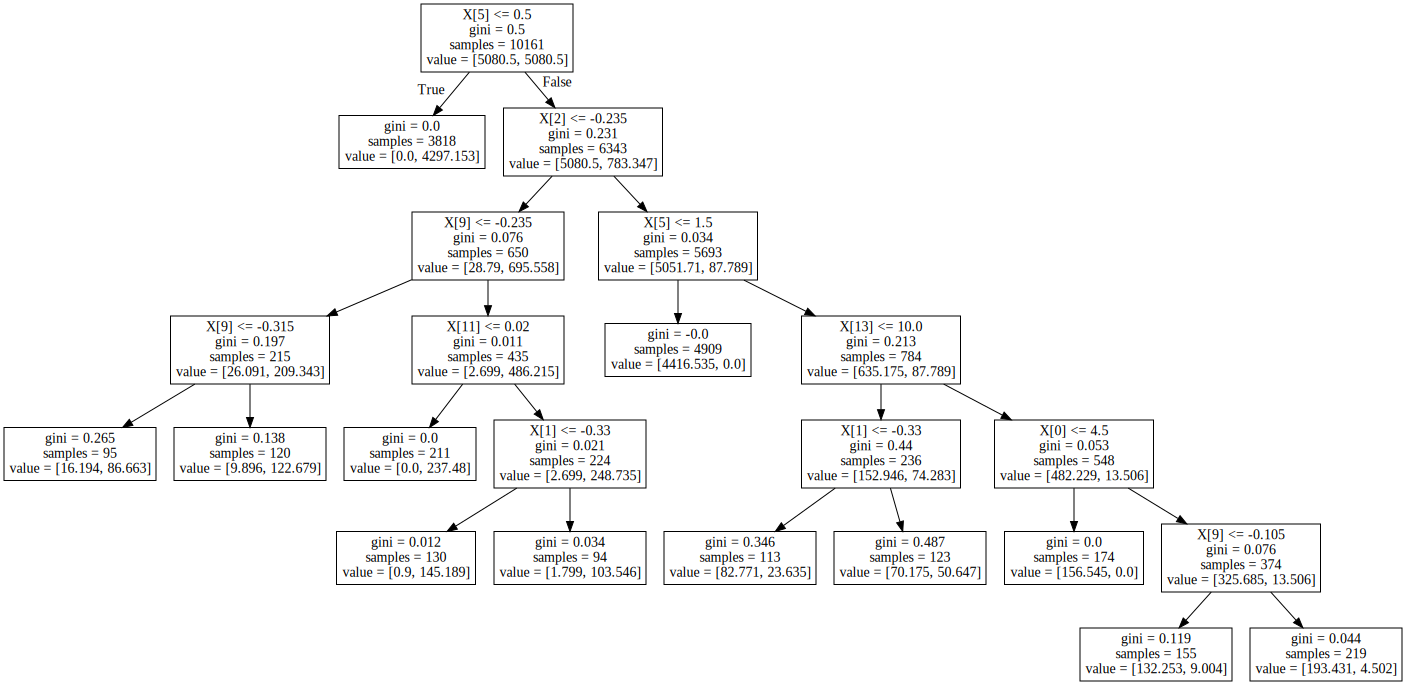

In [40]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(clf_tree, out_file="mytree.dot")
with open("./mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)